# Neural Style Transfer

Neural Style Transfer allow copying style of a image to the content of another image. In this notebook we will implement Neural Style Transfer using a pretrained VGG16 Model.

### Import required libraries

* numpy for manipulating images as if they are array of numbers
* PIL for handing images
* Keras for neural network protoyping
* Scipy for Optimization

In [1]:
import numpy as np
from PIL import Image
import time

from keras import backend
from keras.models import Model
# import pretrained VGG16 model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

D:\Langs\conda_py\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Open content image
Content image is the one on which the style of another image is applied. We are here setting size of image as 256 * 256.

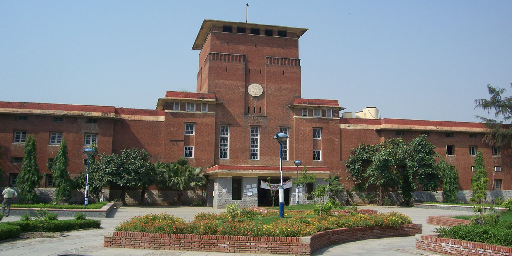

In [5]:
# set height and width of the image
height = 256
width = 512


content_image_path = 'images/content.png'
# open the image
content_image = Image.open(content_image_path)
# resize the image to specifed width and height
content_image = content_image.resize((width, height))
content_image

### Open style imageapplied
The style of style image will applied to the content. 

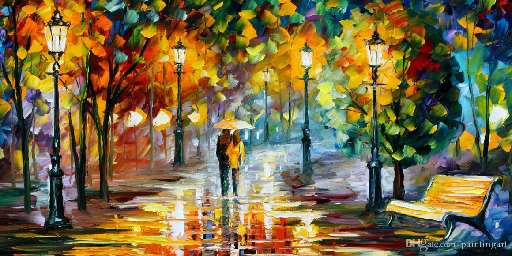

In [7]:
style_image_path = 'images/style_2.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### Preprocess Images
We will convert both imported images to numpy arrays so that these images can be used with our models and optimized. Note we have also extended the dimension of the image so that it can be combined later with style image

In [10]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

(1, 256, 512, 3)


In [11]:
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 256, 512, 3)


### Preprocess images, for use with VGG model
We will do two things:
* subtract the mean RGB values to normalize
* flip the ordering from RGB to BGR

In [12]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

### Create variables for holding images

In [13]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

#### concatenate images so that they can be passed as input to VGG model

In [14]:
input_data = backend.concatenate([content_image, style_image, combination_image], axis=0)
input_data.shape

TensorShape([Dimension(3), Dimension(256), Dimension(512), Dimension(3)])

### Import Pretrained VGG16 Model

Here we are importing VGG model trained on imagenet database

In [15]:
model = VGG16(input_tensor = input_data, weights='imagenet', include_top=False)
# get the layers from model
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 256, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 256, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 128, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 128, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 128, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 64, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 64, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 64, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 64, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 32, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 32, 64, 512) dtype=float32>,
 'block

#### Hyperparamaters
these can be tuned to give more asthetic results

In [16]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

##### This is the loss variable and our optimization algoritm will minimize this loss value.

In [17]:
loss = backend.variable(0.)

### Define content Loss

According to the original paper the content loss is given by:
$$ J_{content}(C,G) = \sum (a^{(c)} - a^{(g)})^{2} $$
                    

In [18]:
# the loss fuction
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

# extract features from layers
layer_features = layers['block2_conv2']
# get content image features
content_image_features = layer_features[0, :, :, :]
# get combination image features
combination_features = layer_features[2, :, :, :]

# optimize loss
loss += content_weight * content_loss(content_image_features, combination_features)

### Define Style Loss Function
The style loss function is bit tricky.  

**What is 'style'?**  
For the purpose of _Neural Style Transfer_, we consider the similarity between the channels of an activation. To get this smilarity we calcualte a gram matrix denoted by 
$$G_{i, j} = v_{i}^{T}v_{j} = np.dot(v_{i}, v_{j})$$ 

Then we will calculate style loss as 
$$J_{style} = \sum_{i=1}^{n_C} \sum_{j=1}^{n_C} (G_{i, j}^{S} - G_{i, j}^{C})^{2}$$ where $G_{i, j}^{S}$ is gram matrix of style image and $G_{i, j}^{C}$ is gram matrix of generated image.

In [19]:
def gram_matrix(x):
    # Our image is in format n_H, n_W, n_C. We need it in format n_C, n_H * n_W. The follwing line does this.
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    # do actual dot product.
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [20]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    
    return backend.sum(backend.square(S - C) / (4. * (channels ** 2) * (size ** 2)))

feature_layers = ['block1_conv2', 'block2_conv2', 
                 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    # select features of style layer
    style_features = layer_features[1, :, :, :]
    # select features of generated image
    combination_features = layer_features[2, :, :, :]
    # calculate style loss
    sl = style_loss(style_features, combination_features)
    # add to loss
    loss += (style_weight / len(feature_layers)) * sl

#### Total variation loss
Add total variation loss for regularization

In [21]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Get gradient for optimization

In [22]:
grads = backend.gradients(loss, combination_image)

### Evaluator class for optimization


In [23]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

#### Do Neural style transfer

We will use Limited-memory BFGS_D (L-BFGS_D or LM-BFGS_D) algorithm to optimize.

In [24]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 111774160000.0
Iteration 0 completed in 102s
Start of iteration 1
Current loss value: 63839945000.0
Iteration 1 completed in 59s
Start of iteration 2
Current loss value: 49975480000.0
Iteration 2 completed in 59s
Start of iteration 3
Current loss value: 40249254000.0
Iteration 3 completed in 61s
Start of iteration 4
Current loss value: 35399766000.0
Iteration 4 completed in 61s
Start of iteration 5
Current loss value: 32581587000.0
Iteration 5 completed in 60s
Start of iteration 6
Current loss value: 30750163000.0
Iteration 6 completed in 63s
Start of iteration 7
Current loss value: 29285425000.0
Iteration 7 completed in 61s
Start of iteration 8
Current loss value: 28170390000.0
Iteration 8 completed in 59s
Start of iteration 9
Current loss value: 27190204000.0
Iteration 9 completed in 59s


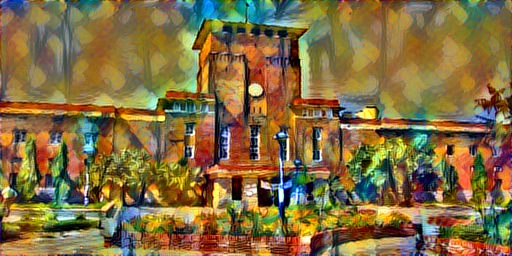

In [25]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)